In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import odl
import pykeops
import imageio

torch.Size([256, 256, 2])


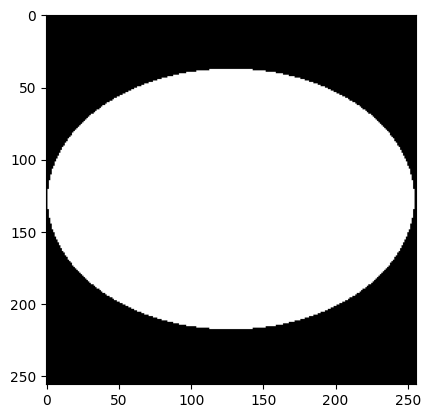

In [ ]:
N = 256
x = torch.linspace(-1, 1, N)
y = torch.linspace(-1, 1, N)
X, Y = torch.meshgrid(x, y, indexing='ij')  # 'ij' para convención matricial

# Si quieres un tensor de shape (N, N, 2) con coordenadas
grid = torch.stack((X, Y), dim=-1)

print(grid.shape)  # -> torch.Size([128, 128, 2])


I0 = torch.where(grid[:, :, 0]**2/0.5 + grid[:, :, 1]**2/0.99 <=1, 1.0, 0.0)

plt.imshow(I0.cpu(), cmap='gray')
plt.show()

I0 = I0.unsqueeze(0).unsqueeze(0)  

In [ ]:
from torch.nn.functional import grid_sample

In [ ]:
def build_displacement_field(t, shape):

    H, W = shape
    
    ys = torch.linspace(-1, 1, H)
    xs = torch.linspace(-1, 1, W)
    Y, X = torch.meshgrid(ys, xs, indexing='ij')
    
    fphi = 1.0  
    
    phi = 0.12 * np.sin(2*np.pi*fphi*t)

    cx = (W-1)/2.0
    cy = (H-1)/2.0
    

    coords_x = X * (W-1)/2.0 + cx
    coords_y = Y * (H-1)/2.0 + cy
    Xc = coords_x - cx
    Yc = coords_y - cy
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)
    Xr = cosphi * Xc - sinphi * Yc
    Yr = sinphi * Xc + cosphi * Yc
    rot_dx = (Xr + cx) - coords_x
    rot_dy = (Yr + cy) - coords_y
    
    
    total_dx = rot_dx
    total_dy = rot_dy
    disp = torch.stack([total_dy, total_dx], axis=0)  # (2, H, W)
    return disp

In [ ]:
def warp_image_torch(img, disp):
    N, C, H, W = img.shape
    if disp.shape[0] == 2 and disp.shape[1] == H and disp.shape[2] == W:
        dy = disp[0]
        dx = disp[1]
    elif disp.shape == (H, W, 2):
        dx = disp[..., 0]
        dy = disp[..., 1]
    else:
        raise ValueError("disp format not recognized")
    
    grid_y, grid_x = torch.meshgrid(
        torch.arange(H, dtype=torch.float32, device=img.device),
        torch.arange(W, dtype=torch.float32, device=img.device),
        indexing='ij'
    )

    coords_x = grid_x + dx
    coords_y = grid_y + dy

    coords_x = 2.0 * coords_x / (W - 1) - 1.0
    coords_y = 2.0 * coords_y / (H - 1) - 1.0

    coords = torch.stack((coords_x, coords_y), dim=-1)
    coords = coords.unsqueeze(0)

    warped = grid_sample(img, coords, mode='bilinear', align_corners=True)
    return warped


def integrate_flow(v_func, n_steps, shape, img):
    H, W = shape
    ys = torch.linspace(-1, 1, H)
    xs = torch.linspace(-1, 1, W)
    Y, X = torch.meshgrid(ys, xs, indexing='ij')
    phi = torch.stack((Y, X), dim=-1)
    warped_images = []
    
    dt = 1.0 / n_steps
    
    for i in range(n_steps):
        t = i * dt
        v_t = v_func[(t, shape)]
        v_phi = torch.nn.functional.grid_sample(
            v_t.permute(2, 0, 1).unsqueeze(0),
            phi.unsqueeze(0), align_corners=True
        )[0].permute(1, 2, 0)
        phi = phi + dt * v_phi
    
    return phi

def v_t_example(t, shape):
    H, W = shape

    ys = torch.linspace(-1, 1, H)
    xs = torch.linspace(-1, 1, W)
    Y, X = torch.meshgrid(ys, xs, indexing='ij')
    
    fphi = 1.0  
    
    phi = 0.12 * np.sin(2*np.pi*fphi*t)
    phi_prime = 0.12* 2*np.pi*fphi* np.cos(2*np.pi*fphi*t)

    cx = (W-1)/2.0
    cy = (H-1)/2.0
    

    coords_x = X * (W-1)/2.0 + cx
    coords_y = Y * (H-1)/2.0 + cy
    Xc = coords_x - cx
    Yc = coords_y - cy
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)
    Xr = -sinphi * phi_prime * Xc - cosphi * phi_prime * Yc
    Yr = cosphi * phi_prime* Xc -sinphi * phi_prime  * Yc
    v_t = torch.stack([Yr, Xr], dim=-1)
    return v_t
    

In [ ]:
T = 60
ts = torch.linspace(0.0, 1.0, T)

In [1]:
H, W = I0[0, 0].shape


phi, warped_images = integrate_flow(v_t_example, 100, (H, W), I0)


frames_uint8 = [(255 * (f.numpy() - f.numpy().min()) / (f.numpy().max() - f.numpy().min())).astype(np.uint8) 
                for f in warped_images]


imageio.mimsave("deformation_video.gif", frames_uint8, fps=5)

NameError: name 'I0' is not defined